# Overview

## Approach

1. Data
2. Parts
3. Style Transfer Network
4. Super-Resolution Network

In [1]:
%matplotlib inline
import importlib
import utils; importlib.reload(utils)
from utils import *
from vgg16 import preprocess, deprocess, VGG16

Using TensorFlow backend.


Keras fit parameters

In [2]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

## 1. Prepare Data

In [3]:
path = './data/'

In [4]:
fnames = glob(path+'**/*.JPEG', recursive=True)
len(fnames)

19440

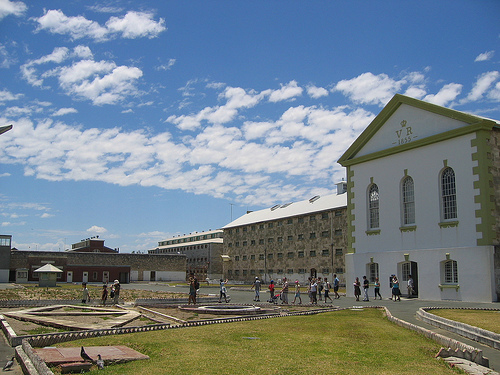

In [5]:
img = Image.open(fnames[777]); img

We load our imagedata and resize it to be 256x256x3 similar to the paper.

CHECK: Input images (x) has to be preprocessed in accordance with VGG16 network (Loss Network)

In [6]:
x_gen = get_batches(path+'train/',target_size=(256, 256), class_mode=None)

Found 19439 images belonging to 774 classes.


## 2. Parts

#### Reflection Padding
The supplementary material mentions the use of reflection padding - implemented as Keras custom layer

In [7]:
class ReflectionPadding2d(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2d, self).__init__(**kwargs)
        
    def compute_output_shape(self, shape):
        return (shape[0], shape[1] + 2 * self.padding[0], shape[2] + 2 * self.padding[1], shape[3])
    
    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

Test of the reflection padding layer

In [8]:
test_img = np.array(img)

In [9]:
inp = Input(test_img.shape)
ref_model = Model(inp, ReflectionPadding2d((40, 10))(inp))
ref_model.compile('adam', 'mse')

In [10]:
test_img = np.expand_dims(test_img, 0); test_img.shape

(1, 375, 500, 3)

In [11]:
pred = ref_model.predict(test_img)

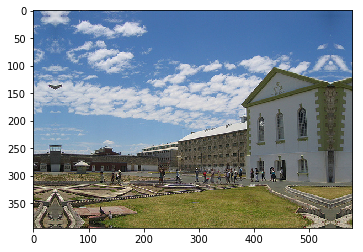

In [12]:
plt.imshow(pred[0].astype('uint8'))

#### Downsampling (ConvBlock)

Convolutional layers using BatchNormalization and (optional) ReLU activation

In [13]:
def conv_block(x, filters, size=(3,3), strides=(2,2), padding='same', act=True):
    x = Convolution2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

#### Upsampling

Method from paper and method from distill paper

##### Deconvolutional Block

In [14]:
def deconv_block(x, filters, size=(3,3), strides=(2,2)):
    x = Deconvolution2D(filters, size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

##### Upsamling Block

In [15]:
# TODO: implement

#### Residual Blocks

The supplementary material mentions the use of no padding. A 3x3 convolution with no padding reduces the size of a feature map by 1 pixel on each side – the identity connection (ip) performs a center crop on the input feature map.

##### ResBlock - Super-Resolution

In [16]:
def res_block(ip, filters, index=0):
    x = conv_block(ip, filters, strides=(1,1))
    x = conv_block(x, filters, strides=(1,1), act=False)
    return add([x, ip])

##### ResBlock - Style Transfer (no padding)

In [17]:
def res_crop_block(ip, filters, index=0):
    x = conv_block(ip, filters, strides=(1,1), padding='valid')
    x = conv_block(x, filters, strides=(1,1), padding='valid', act=False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return add([x, ip])

## 3. Style Transfer

* requires calculation of both `style_loss` and `content_loss`
* style target `y_s`, content target `y_c` and transformed input `y_hat`

In [18]:
batch = x_gen.next()

In [19]:
input_shape = batch[0].shape; input_shape

(256, 256, 3)

Style (`y_s`) image for Style Transfer

In [20]:
style = Image.open('./data/picasso.jpg')
style = style.resize(img.size)
y_s = np.array(style)[:input_shape[0], :input_shape[1], :input_shape[2]]; y_s.shape

(256, 256, 3)

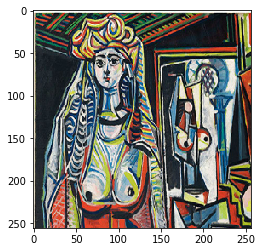

In [21]:
plt.imshow(y_s)

### Image Transform Network

In [22]:
inp = Input(input_shape)
x = ReflectionPadding2d((40,40))(inp)
x = conv_block(x, 32, size=(9,9), strides=(1,1))
x = conv_block(x, 64, size=(3,3), strides=(2,2))
x = conv_block(x, 128, size=(3,3), strides=(2,2))
for i in range(5): x = res_crop_block(x, 128, i)
x = deconv_block(x, 64, size=(3,3), strides=(2,2))
x = deconv_block(x, 32, size=(3,3), strides=(2,2))
x = deconv_block(x, 3, size=(9,9), strides=(1,1))
x = Conv2D(3, 9, 9, activation='tanh', border_mode='same')(x)
out = Lambda(lambda x: (x+1)*127.5)(x)

/home/mark/.conda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (9, 9), activation="tanh", padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [23]:
style_model = Model(inp, x)
style_model.compile('adam', 'mse')
style_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
reflection_padding2d_2 (Reflecti (None, 336, 336, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 336, 336, 32)  7808        reflection_padding2d_2[0][0]     
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 336, 336, 32)  128         conv2d_1[0][0]                   
___________________________________________________________________________________________

### Loss Network(VGG16)

We preprocess the data for the VGG16 network and change max-pooling layers to average-pooling layers. 

In [24]:
vgg_input = Input(input_shape)
input_tensor=Lambda(preprocess)(vgg_input)

In [25]:
vgg_model = VGG16(include_top=False,
                  input_tensor=input_tensor, int_pooling='avg')

In [26]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
__________

We don't want to retrain the layers in our loss network

In [27]:
for layer in vgg_model.layers:
    layer.trainable = False

For style loss we select the feature-map/activation of the last layer in the block.

In [28]:
def get_output(model, layer_i):
    return model.get_layer(f'block{layer_i}_conv2').output

In [29]:
vgg_content = Model(vgg_input, [get_output(vgg_model, i) for i in [2,3,4,5]])

In [30]:
style_maps = [K.variable(pred) for pred in vgg_content.predict(np.expand_dims(y_s, 0))]

In [31]:
[K.eval(K.shape(act)) for act in style_maps]

[array([  1, 128, 128, 128], dtype=int32),
 array([  1,  64,  64, 256], dtype=int32),
 array([  1,  32,  32, 512], dtype=int32),
 array([  1,  16,  16, 512], dtype=int32)]

We use the structure of our original image x as our content target (called feature loss in paper)

In [32]:
yc_act = vgg_content(vgg_input); yc_act

[<tf.Tensor 'model_3/block2_conv2/Relu:0' shape=(?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'model_3/block3_conv2/Relu:0' shape=(?, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'model_3/block4_conv2/Relu:0' shape=(?, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'model_3/block5_conv2/Relu:0' shape=(?, 16, 16, 512) dtype=float32>]

In [33]:
yhat_act = vgg_content(out); yhat_act

[<tf.Tensor 'model_3_1/block2_conv2/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 <tf.Tensor 'model_3_1/block3_conv2/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'model_3_1/block4_conv2/Relu:0' shape=(?, ?, ?, 512) dtype=float32>,
 <tf.Tensor 'model_3_1/block5_conv2/Relu:0' shape=(?, ?, ?, 512) dtype=float32>]

### Loss Function

Total loss is the mse for the content loss and the gram-matrix for the style loss

In [34]:
def mean_sqr(diff):
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [35]:
def gram_matrix(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    shape = K.shape(x)
    feat = K.reshape(x, (shape[0], shape[1], shape[2]*shape[3]))
    num = K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1)))
    den = K.prod(K.cast(shape[1:], K.floatx()))
    return num/den

In [36]:
weights = [0.1, 0.2, 0.6, 0.1]
def total_loss(x):
    loss = 0
    n = len(style_maps)
    for i in range(n):
        loss += mean_sqr(gram_matrix(x[i+n]) - gram_matrix(style_maps[i])) / 2.
        loss += mean_sqr(x[i]-x[i+n]) * weights[i]
    return loss

In [37]:
loss = Lambda(total_loss)(yc_act+yhat_act)

### Train

In [38]:
style_model = Model([inp, vgg_input], loss)

In [39]:
x = np.concatenate([x_gen.next() for  i in range(20)]); x.shape

(1280, 256, 256, 3)

keras requires a target pred, even-though this is a GAN that doesn't require targets in the same way as classfication

In [40]:
# we'll just set target to zero
targ = np.zeros((x.shape[0], 1)); targ.shape

(1280, 1)

In [41]:
style_model.compile('adam', 'mae')
style_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
reflection_padding2d_2 (Reflecti (None, 336, 336, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 336, 336, 32)  7808        reflection_padding2d_2[0][0]     
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 336, 336, 32)  128         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [42]:
style_model.fit([x, x], targ, 8, 15)

Epoch 1/15
1280/1280 [==============================] - 50s - loss: 405.6352    
Epoch 2/15
1280/1280 [==============================] - 48s - loss: 325.4896    
Epoch 3/15
1280/1280 [==============================] - 48s - loss: 304.7404    
Epoch 4/15
1280/1280 [==============================] - 48s - loss: 295.6174    
Epoch 5/15
1280/1280 [==============================] - 48s - loss: 289.7914    
Epoch 6/15
1280/1280 [==============================] - 48s - loss: 285.1259    
Epoch 7/15
1280/1280 [==============================] - 48s - loss: 280.4991    
Epoch 8/15
1280/1280 [==============================] - 48s - loss: 277.7086    
Epoch 9/15
1280/1280 [==============================] - 48s - loss: 274.7885    
Epoch 10/15
1280/1280 [==============================] - 48s - loss: 272.5933    
Epoch 11/15
1280/1280 [==============================] - 48s - loss: 270.2068    
Epoch 12/15
1280/1280 [==============================] - 48s - loss: 268.6326    
Epoch 13/15
1280/1280 [==

In [43]:
K.set_value(style_model.optimizer.lr, 1e-4)
style_model.fit([x, x], targ, 16, 1)

Epoch 1/1
1280/1280 [==============================] - 49s - loss: 256.8246    


In [44]:
top_model = Model(inp, out)

In [45]:
pred = top_model.predict(x[:20])

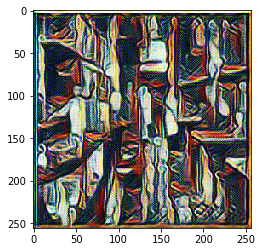

In [48]:
plt.imshow(np.round(pred[3]).astype(np.uint8))

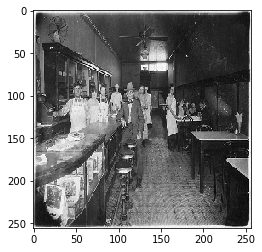

In [49]:
plt.imshow(x[2].astype(np.uint8))

## 4. Super-Resolution Network

* We're only interested in the `content_loss`
* `yc = x`
* (we need both `x_high_res` and `low x_low_res`)

### Architecture